In [1]:
import io
import itertools

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bmh')

import seaborn as sns
sns.set(style='darkgrid')

%matplotlib inline

In [2]:
df = pd.read_csv('./perf_results.txt')
df['id'] = 'k=' + df['k'].astype('str') + ',n=' + df['n_classes'].astype('str')
df = df[~((df['alg'] == 'dac_ad') & (df['forward'] == 0))]

In [3]:
df

,k,n_classes,batch_size,n_trials,tau,cuda,alg,forward,mean,std,id
0,5,1000,256,50,1.0,True,sum,1,0.043735,0.000386,"k=5,n=1000"
1,5,1000,256,50,1.0,True,dac_md,1,0.022706,0.000245,"k=5,n=1000"
2,5,1000,256,50,None,True,lml,1,0.008128,0.000229,"k=5,n=1000"
4,5,1000,256,50,1.0,True,dac_md,0,0.013306,0.000914,"k=5,n=1000"
5,5,1000,256,50,None,True,lml,0,0.001017,0.000157,"k=5,n=1000"
6,5,1000,256,50,1.0,False,sum,1,0.029466,0.002650,"k=5,n=1000"
7,5,1000,256,50,1.0,False,dac_md,1,0.018666,0.000290,"k=5,n=1000"
8,5,1000,256,50,None,False,lml,1,0.071008,0.004327,"k=5,n=1000"
10,5,1000,256,50,1.0,False,dac_md,0,0.379664,0.010059,"k=5,n=1000"
11,5,1000,256,50,None,False,lml,0,0.008397,0.001672,"k=5,n=1000"


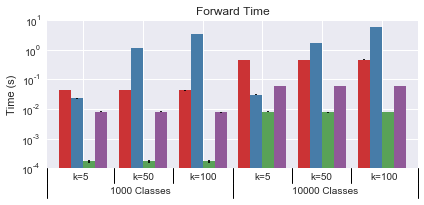

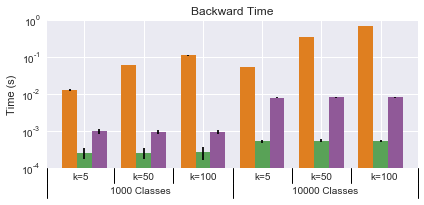

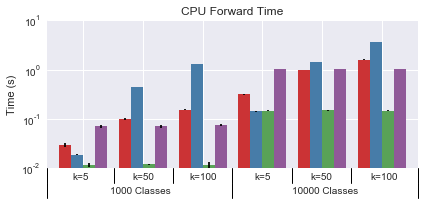

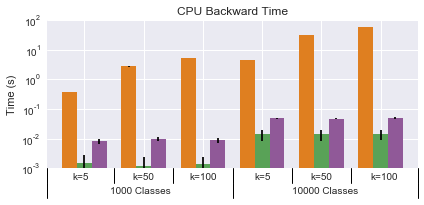

In [4]:
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib
def add_line(ax, xpos, ypos):
    line = plt.Line2D(
        [xpos, xpos], [ypos + .1, ypos],
        transform=ax.transAxes,
        color='black', linewidth=1,
    )
    line.set_clip_on(False)
    ax.add_line(line)

# https://stackoverflow.com/questions/42017049/seaborn-how-to-add-error-bars-on-a-grouped-barplot
def grouped_barplot(df, cat,subcat, val , err, title=None, palette=None, ylim=None):
    if palette is None:
        palette = sns.color_palette('Set1', desat=0.75)
    
    fig, ax = plt.subplots(figsize=(6,3))
    
    u = df[cat].unique()
    x = np.arange(len(u))
    
    # Hacky way of changing order so LML is last.
    subx = df[subcat].unique()
    t = subx[-1]
    subx[-1] = subx[-2]
    subx[-2] = t
    
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        assert len(x) == len(dfg[val].values)
        assert len(x) == len(dfg[err].values)
        ax.bar(
            x+offsets[i], dfg[val].values, width=width, 
            label="{}".format(gr), yerr=dfg[err].values,
            color=palette[i]
        )
    ax.set_ylabel('Time (s)')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xticks(x)
#     ax.set_xlim((x))
#     print(len(subx))
    ax.set_xlim(x[0]-(len(subx)/2.+1.)*width, x[-1]+(len(subx)/2.+1.)*width)
    ax.set_xticklabels(['' for _ in range(len(u))], rotation=-20, ha='left')
    
    # Hacky way of getting nice xlabels:
    nk = 3*2
    n_chunks = 4*nk+1
    bar_width = 1./n_chunks
    group_width = 4.*bar_width
    pos = 0
    for i in range(nk+1):
        add_line(ax, pos, -.1)
        if i in [0, nk-1]:
            newpos = pos+0.5*bar_width
        newpos += group_width
        
        if i < nk:
            center = (newpos+pos)/2
            txt = 'k={}'.format([5, 50, 100][i % 3])
            ax.text(center, -.07, txt, ha='center', transform=ax.transAxes)
        
        pos = newpos
        
    nk = 3*2
    n_chunks = 4*nk+1
    bar_width = 1./n_chunks
    group_width = 4.*bar_width
    pos = 0
    for i in range(3):
        add_line(ax, pos, -.2)
        if i in [0, 1]:
            newpos = pos+0.5*bar_width
        newpos += 3.*group_width
        
        if i < 2:
            center = (newpos+pos)/2
            txt = '{} Classes'.format([1000, 10000][i % 2])
            ax.text(center, -.17, txt, ha='center', transform=ax.transAxes)
        
        pos = newpos
    
#     ax.legend()
    ax.set_yscale('log')
    if title is not None:
        ax.set_title(title)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.2)
    fig.savefig('{}.pdf'.format(title.lower().replace(' ', '-')))
    return fig, ax

title = 'Forward Time'
palette = sns.color_palette('Set1', desat=0.75)
dfi = df[(df['cuda'] == True) & (df['forward'] == 1)]
fig, ax = grouped_barplot(dfi, 'id', 'alg', 'mean', 'std', title, palette, ylim=(1e-4, 1e1))

title = 'Backward Time'
# _palette = [palette[3], palette[2]]
_palette = [palette[4], palette[2], palette[3]]
dfi = df[(df['cuda'] == True) & (df['forward'] == 0)]
fig, ax = grouped_barplot(dfi, 'id', 'alg', 'mean', 'std', title, _palette, ylim=(1e-4, 1e0))

title = 'CPU Forward Time'
dfi = df[(df['cuda'] == False) & (df['forward'] == 1)]
fig, ax = grouped_barplot(dfi, 'id', 'alg', 'mean', 'std', title, palette, ylim=(1e-2, 1e1))

title = 'CPU Backward Time'
dfi = df[(df['cuda'] == False) & (df['forward'] == 0)]
fig, ax = grouped_barplot(dfi, 'id', 'alg', 'mean', 'std', title, _palette, ylim=(1e-3, 1e2))